# 4.7.Transfer_Learning_MobileNet2_SGD_New_Head_v1_220_epochs

In [ ]:
#!pip install sklearn
#!pip install imutils

In [1]:
import tensorflow as tf

from tensorflow.keras.applications import MobileNetV2

from tensorflow_examples.lite.model_maker.core.data_util.image_dataloader import ImageClassifierDataLoader

import matplotlib.pyplot as plt
import numpy as np

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


# Empezamos el entrenamiento

In [3]:
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from pyimagesearch.preprocessing import ImageToArrayPreprocessor
from pyimagesearch.preprocessing import AspectAwarePreprocessor
from pyimagesearch.datasets import SimpleDatasetLoader

from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint

from imutils import paths
import numpy as np
import os
import cv2

# Leemos la data

In [4]:
img_size = 224
path_train = 'data_' + str(img_size) + '/train'
path_validation = 'data_' + str(img_size) + '/validation'
path_checkpoints = 'checkpoint_MobileNet'

In [13]:
imagePaths_train = list(paths.list_images(path_train))
imagePaths_validation = list(paths.list_images(path_validation))
classNames = [pt.split(os.path.sep)[-2] for pt in imagePaths_train]
classNames = [str(x) for x in np.unique(classNames)]

print("etiquetas del entrenamiento")
print(classNames)

#Códificando las etiquetas en númerops
print("codificando etiquetas")
le = LabelEncoder()
classNames_ids = le.fit_transform(classNames)
print(classNames_ids)

etiquetas del entrenamiento
['10', '100', '20', '200', '50']
codificando etiquetas
[0 1 2 3 4]


In [ ]:
iap = ImageToArrayPreprocessor()
sdl = SimpleDatasetLoader(preprocessors=[iap])

print('Cargando data para el entrenamiento')
data_train, labels_train = sdl.load(imagePaths_train, verbose=5000)

print('Cargando data para la validación')
data_validation, labels_validation = sdl.load(imagePaths_validation, verbose=500)

print('Binarizando los labels')
labels_train = LabelBinarizer().fit_transform(labels_train)
labels_validation = LabelBinarizer().fit_transform(labels_validation)

print('Carga terminada')


# Creando el modelo base

In [5]:
base_model = MobileNetV2(
    include_top=False,
    weights='imagenet',
    input_shape=(img_size,img_size,3)
)

# Congelamos las capas para el entrenamiento

In [6]:
for layer in base_model.layers:
    layer.trainable = True

# Creamos la nueva cabecera

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D

# Creamos varios modelos para luego realizar un ensamblaje

In [20]:
path_ensembles = 'ensembles_MobileNetV2'
batch_size = 32
epochs = 220

# Entrenamiento

In [ ]:
'''
print('Normalizando los datos')
data_train = data_train.astype("float") / 255.0
data_validation = data_validation.astype("float") / 255.0

print('Generando la data para el entrenamiento')
aug_train = ImageDataGenerator()
aug_train.fit(data_train)
train_generator = aug_train.flow(data_train, labels_train, batch_size=batch_size)

aug_validation = ImageDataGenerator()
aug_validation.fit(data_validation)
validation_generator = aug_validation.flow(data_validation, labels_validation, batch_size=batch_size)
print('Terminado')
'''

In [10]:
aug_train = ImageDataGenerator(rescale=1. / 255)
#aug_train.fit(data_train)
train_generator = aug_train.flow_from_directory(path_train,
                                                target_size=(img_size, img_size),
                                                batch_size=batch_size)

Found 59812 images belonging to 5 classes.


In [11]:
aug_validation = ImageDataGenerator(rescale=1. / 255)
#aug_validation.fit(data_validation)
validation_generator = aug_validation.flow_from_directory(path_validation,
                                                          target_size=(img_size, img_size),
                                                          batch_size=batch_size)

Found 3028 images belonging to 5 classes.


In [14]:
model = tf.keras.Sequential([base_model,
                             GlobalAveragePooling2D(),
                             Dense(1024, activation='relu'),
                             Dense(len(classNames_ids), activation='softmax')
                            ])

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              1311744   
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 5125      
Total params: 3,574,853
Trainable params: 3,540,741
Non-trainable params: 34,112
_________________________________________________________________


In [16]:
#optimizer = Adam(learning_rate=0.0001)
#optimizer = RMSprop(learning_rate=0.0001)
optimizer = SGD(learning_rate=0.0001)

loss = 'categorical_crossentropy'
metrics=["accuracy"]

model.compile(loss=loss,
              optimizer=optimizer,
              metrics=metrics)


# Configurando checkpoint

In [21]:
fname = os.path.sep.join([path_checkpoints, 
                          'epoch-{epoch:03d}-val_loss:{val_loss:.4f}-val_accuracy:{val_accuracy:.4f}.hdf5'])
checkpoint = ModelCheckpoint(fname,
                             monitor='val_accuracy',
                             save_best_only=True,
                             mode='max',
                             verbose=1)
callbacks = [checkpoint]
#callbacks = []

In [22]:
#entrenando el modelo
history = model.fit_generator(train_generator,
                              steps_per_epoch=len(train_generator),
                              validation_data=validation_generator,
                              epochs = epochs,
                              callbacks=callbacks,
                              verbose = 1)

Epoch 1/220
1870/1870 [==============================] - ETA: 0s - loss: 0.1280 - accuracy: 0.9882
Epoch 00001: val_accuracy improved from -inf to 0.67867, saving model to checkpoint_MobileNet/epoch-001-val_loss:0.8791-val_accuracy:0.6787.hdf5
1870/1870 [==============================] - 239s 128ms/step - loss: 0.1280 - accuracy: 0.9882 - val_loss: 0.8791 - val_accuracy: 0.6787
Epoch 2/220
1870/1870 [==============================] - ETA: 0s - loss: 0.0843 - accuracy: 0.9920
Epoch 00002: val_accuracy improved from 0.67867 to 0.68527, saving model to checkpoint_MobileNet/epoch-002-val_loss:0.8533-val_accuracy:0.6853.hdf5
1870/1870 [==============================] - 240s 128ms/step - loss: 0.0843 - accuracy: 0.9920 - val_loss: 0.8533 - val_accuracy: 0.6853
Epoch 3/220
1870/1870 [==============================] - ETA: 0s - loss: 0.0619 - accuracy: 0.9936
Epoch 00003: val_accuracy improved from 0.68527 to 0.69617, saving model to checkpoint_MobileNet/epoch-003-val_loss:0.8351-val_accuracy:

1870/1870 [==============================] - ETA: 0s - loss: 0.0090 - accuracy: 0.9986
Epoch 00023: val_accuracy did not improve from 0.72490
1870/1870 [==============================] - 239s 128ms/step - loss: 0.0090 - accuracy: 0.9986 - val_loss: 0.8216 - val_accuracy: 0.7226
Epoch 24/220
1870/1870 [==============================] - ETA: 0s - loss: 0.0086 - accuracy: 0.9988
Epoch 00024: val_accuracy did not improve from 0.72490
1870/1870 [==============================] - 239s 128ms/step - loss: 0.0086 - accuracy: 0.9988 - val_loss: 0.8177 - val_accuracy: 0.7242
Epoch 25/220
1870/1870 [==============================] - ETA: 0s - loss: 0.0075 - accuracy: 0.9990
Epoch 00025: val_accuracy did not improve from 0.72490
1870/1870 [==============================] - 238s 127ms/step - loss: 0.0075 - accuracy: 0.9990 - val_loss: 0.8202 - val_accuracy: 0.7239
Epoch 26/220
1870/1870 [==============================] - ETA: 0s - loss: 0.0079 - accuracy: 0.9989
Epoch 00026: val_accuracy did not imp

1870/1870 [==============================] - ETA: 0s - loss: 0.0040 - accuracy: 0.9995
Epoch 00050: val_accuracy did not improve from 0.72820
1870/1870 [==============================] - 240s 128ms/step - loss: 0.0040 - accuracy: 0.9995 - val_loss: 0.8686 - val_accuracy: 0.7262
Epoch 51/220
1870/1870 [==============================] - ETA: 0s - loss: 0.0038 - accuracy: 0.9995
Epoch 00051: val_accuracy did not improve from 0.72820
1870/1870 [==============================] - 238s 127ms/step - loss: 0.0038 - accuracy: 0.9995 - val_loss: 0.8719 - val_accuracy: 0.7259
Epoch 52/220
1870/1870 [==============================] - ETA: 0s - loss: 0.0038 - accuracy: 0.9994
Epoch 00052: val_accuracy did not improve from 0.72820
1870/1870 [==============================] - 244s 130ms/step - loss: 0.0038 - accuracy: 0.9994 - val_loss: 0.8749 - val_accuracy: 0.7252
Epoch 53/220
1870/1870 [==============================] - ETA: 0s - loss: 0.0041 - accuracy: 0.9992
Epoch 00053: val_accuracy did not imp

1870/1870 [==============================] - ETA: 0s - loss: 0.0026 - accuracy: 0.9997
Epoch 00078: val_accuracy did not improve from 0.72820
1870/1870 [==============================] - 238s 127ms/step - loss: 0.0026 - accuracy: 0.9997 - val_loss: 0.9171 - val_accuracy: 0.7252
Epoch 79/220
1870/1870 [==============================] - ETA: 0s - loss: 0.0026 - accuracy: 0.9996
Epoch 00079: val_accuracy did not improve from 0.72820
1870/1870 [==============================] - 238s 127ms/step - loss: 0.0026 - accuracy: 0.9996 - val_loss: 0.9179 - val_accuracy: 0.7242
Epoch 80/220
1870/1870 [==============================] - ETA: 0s - loss: 0.0023 - accuracy: 0.9998
Epoch 00080: val_accuracy did not improve from 0.72820
1870/1870 [==============================] - 239s 128ms/step - loss: 0.0023 - accuracy: 0.9998 - val_loss: 0.9201 - val_accuracy: 0.7229
Epoch 81/220
1870/1870 [==============================] - ETA: 0s - loss: 0.0024 - accuracy: 0.9997
Epoch 00081: val_accuracy did not imp

1870/1870 [==============================] - ETA: 0s - loss: 0.0016 - accuracy: 0.9999
Epoch 00106: val_accuracy did not improve from 0.72820
1870/1870 [==============================] - 239s 128ms/step - loss: 0.0016 - accuracy: 0.9999 - val_loss: 0.9475 - val_accuracy: 0.7252
Epoch 107/220
1870/1870 [==============================] - ETA: 0s - loss: 0.0019 - accuracy: 0.9997
Epoch 00107: val_accuracy did not improve from 0.72820
1870/1870 [==============================] - 239s 128ms/step - loss: 0.0019 - accuracy: 0.9997 - val_loss: 0.9493 - val_accuracy: 0.7252
Epoch 108/220
1870/1870 [==============================] - ETA: 0s - loss: 0.0017 - accuracy: 0.9998
Epoch 00108: val_accuracy did not improve from 0.72820
1870/1870 [==============================] - 242s 129ms/step - loss: 0.0017 - accuracy: 0.9998 - val_loss: 0.9494 - val_accuracy: 0.7239
Epoch 109/220
1870/1870 [==============================] - ETA: 0s - loss: 0.0019 - accuracy: 0.9997
Epoch 00109: val_accuracy did not 

1870/1870 [==============================] - ETA: 0s - loss: 0.0015 - accuracy: 0.9998
Epoch 00134: val_accuracy did not improve from 0.72820
1870/1870 [==============================] - 239s 128ms/step - loss: 0.0015 - accuracy: 0.9998 - val_loss: 0.9834 - val_accuracy: 0.7223
Epoch 135/220
1870/1870 [==============================] - ETA: 0s - loss: 0.0014 - accuracy: 0.9998
Epoch 00135: val_accuracy did not improve from 0.72820
1870/1870 [==============================] - 239s 128ms/step - loss: 0.0014 - accuracy: 0.9998 - val_loss: 0.9849 - val_accuracy: 0.7236
Epoch 136/220
1870/1870 [==============================] - ETA: 0s - loss: 0.0013 - accuracy: 0.9998
Epoch 00136: val_accuracy did not improve from 0.72820
1870/1870 [==============================] - 239s 128ms/step - loss: 0.0013 - accuracy: 0.9998 - val_loss: 0.9846 - val_accuracy: 0.7229
Epoch 137/220
1870/1870 [==============================] - ETA: 0s - loss: 0.0014 - accuracy: 0.9998
Epoch 00137: val_accuracy did not 

1870/1870 [==============================] - ETA: 0s - loss: 0.0010 - accuracy: 0.9999
Epoch 00162: val_accuracy did not improve from 0.72820
1870/1870 [==============================] - 245s 131ms/step - loss: 0.0010 - accuracy: 0.9999 - val_loss: 1.0142 - val_accuracy: 0.7196
Epoch 163/220
1870/1870 [==============================] - ETA: 0s - loss: 0.0011 - accuracy: 0.9999
Epoch 00163: val_accuracy did not improve from 0.72820
1870/1870 [==============================] - 240s 128ms/step - loss: 0.0011 - accuracy: 0.9999 - val_loss: 1.0136 - val_accuracy: 0.7209
Epoch 164/220
1870/1870 [==============================] - ETA: 0s - loss: 0.0011 - accuracy: 0.9998
Epoch 00164: val_accuracy did not improve from 0.72820
1870/1870 [==============================] - 241s 129ms/step - loss: 0.0011 - accuracy: 0.9998 - val_loss: 1.0171 - val_accuracy: 0.7196
Epoch 165/220
1870/1870 [==============================] - ETA: 0s - loss: 0.0011 - accuracy: 0.9998
Epoch 00165: val_accuracy did not 

Epoch 190/220
1870/1870 [==============================] - ETA: 0s - loss: 0.0010 - accuracy: 0.9998
Epoch 00190: val_accuracy did not improve from 0.72820
1870/1870 [==============================] - 239s 128ms/step - loss: 0.0010 - accuracy: 0.9998 - val_loss: 1.0320 - val_accuracy: 0.7196
Epoch 191/220
1870/1870 [==============================] - ETA: 0s - loss: 9.4846e-04 - accuracy: 0.9999
Epoch 00191: val_accuracy did not improve from 0.72820
1870/1870 [==============================] - 238s 127ms/step - loss: 9.4846e-04 - accuracy: 0.9999 - val_loss: 1.0287 - val_accuracy: 0.7223
Epoch 192/220
1870/1870 [==============================] - ETA: 0s - loss: 0.0011 - accuracy: 0.9998
Epoch 00192: val_accuracy did not improve from 0.72820
1870/1870 [==============================] - 237s 127ms/step - loss: 0.0011 - accuracy: 0.9998 - val_loss: 1.0320 - val_accuracy: 0.7209
Epoch 193/220
1870/1870 [==============================] - ETA: 0s - loss: 9.6290e-04 - accuracy: 0.9999
Epoch 00

Epoch 218/220
1870/1870 [==============================] - ETA: 0s - loss: 9.4465e-04 - accuracy: 0.9999
Epoch 00218: val_accuracy did not improve from 0.72820
1870/1870 [==============================] - 238s 127ms/step - loss: 9.4465e-04 - accuracy: 0.9999 - val_loss: 1.0573 - val_accuracy: 0.7196
Epoch 219/220
1870/1870 [==============================] - ETA: 0s - loss: 8.8932e-04 - accuracy: 0.9998
Epoch 00219: val_accuracy did not improve from 0.72820
1870/1870 [==============================] - 239s 128ms/step - loss: 8.8932e-04 - accuracy: 0.9998 - val_loss: 1.0625 - val_accuracy: 0.7186
Epoch 220/220
1870/1870 [==============================] - ETA: 0s - loss: 7.5922e-04 - accuracy: 0.9999
Epoch 00220: val_accuracy did not improve from 0.72820
1870/1870 [==============================] - 239s 128ms/step - loss: 7.5922e-04 - accuracy: 0.9999 - val_loss: 1.0604 - val_accuracy: 0.7190


In [23]:
#guardando el modelo
p = [path_ensembles, "model_220_SGD.model"]
model.save(os.path.sep.join(p))

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: ensembles_MobileNetV2/model_220_SGD.model/assets


In [24]:
#evaluando el modelo
predictions = model.predict(data_validation, batch_size=batch_size)
print(classification_report(labels_validation.argmax(axis=1),
                            predictions.argmax(axis=1),
                            target_names=classNames))

NameError: name 'data_validation' is not defined

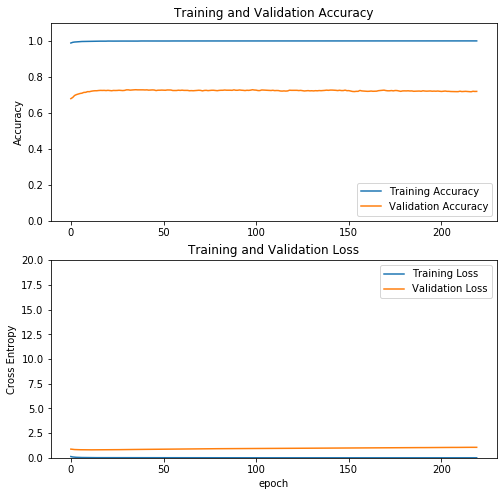

In [25]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
#plt.ylim([min(plt.ylim()),1])
plt.ylim([0,1.1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
#plt.ylim([0,1.0])
plt.ylim([0,20])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# Tomando 25 imágenes de validación y observando el resultado

INFO:tensorflow:Load image with size: 3028, num_label: 5, labels: 10, 100, 20, 200, 50.


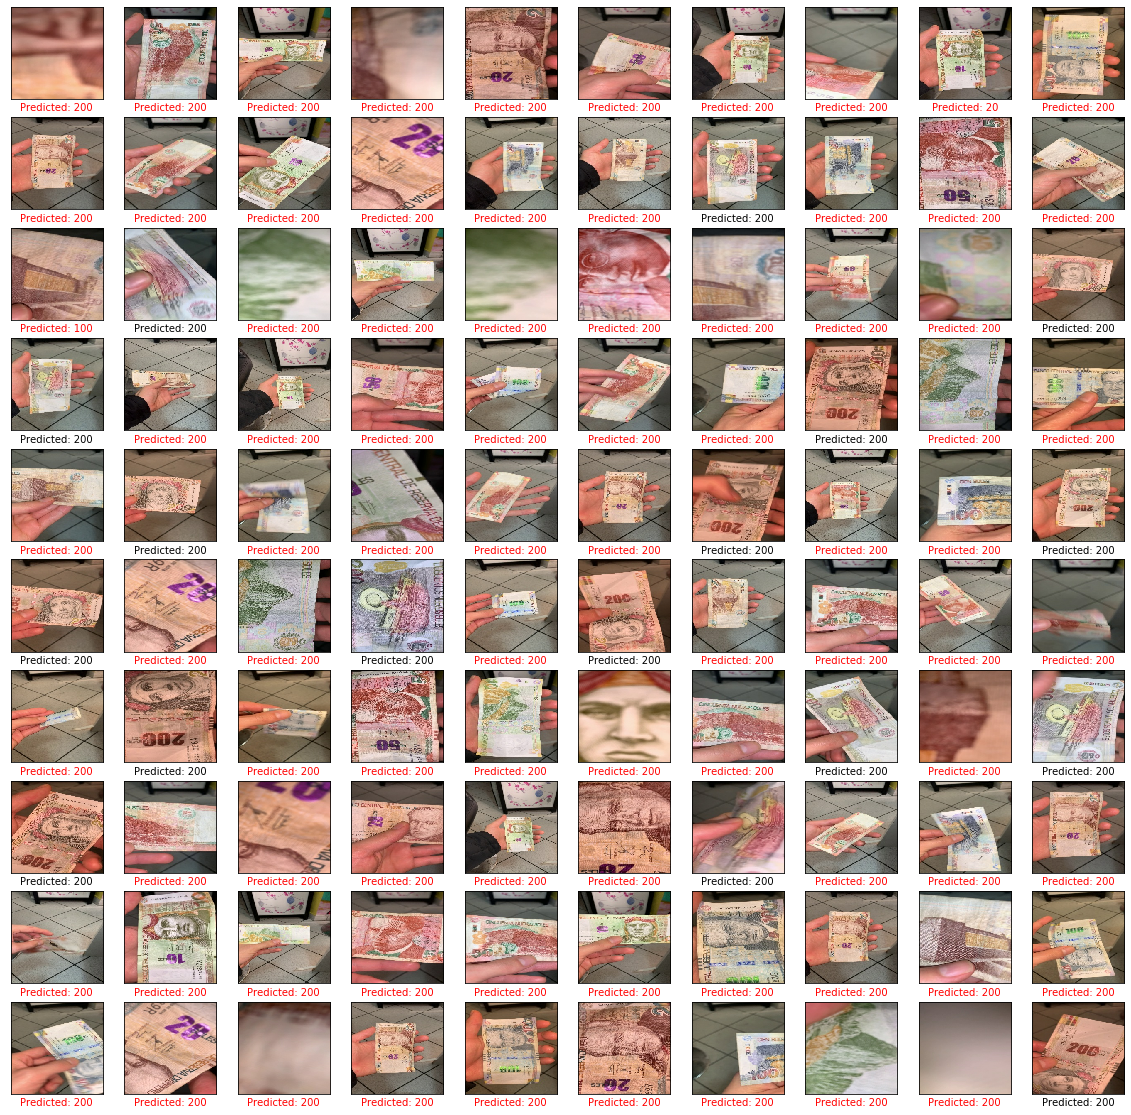

In [31]:
test_data = ImageClassifierDataLoader.from_folder(path_validation)

def get_label_color(val1, val2):
  if val1 == val2:
    return 'black'
  else:
    return 'red'

plt.figure(figsize=(20, 20))

for i, (image, label) in enumerate(test_data.dataset.take(100)):
    ax = plt.subplot(10, 10, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(image.numpy(), cmap=plt.cm.gray)
    
    # predict
    swapped = np.moveaxis(image, 0, 1)
    arr4d = np.expand_dims(swapped, 0)
    id_predict = np.argmax(model.predict(arr4d))
    predict_label = classNames[id_predict]
    
    color = get_label_color(predict_label, test_data.index_to_label[label.numpy()])
    #color = 'black'
    ax.xaxis.label.set_color(color)
    plt.xlabel('Predicted: %s' % predict_label)
plt.show()